In [1]:
#import packages
import numpy as np
import pandas as pd
import os
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from datetime import date, timedelta
import datetime
import matplotlib.pyplot as plt

### Plotly tools 
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

## Additional dependencies

In [2]:
import seaborn as sns
### We use Lale for our model development
import lale
from lale.lib.lale import NoOp, Hyperopt
from sklearn.decomposition import PCA
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import StandardScaler as Standard, MinMaxScaler as MinMax
from xgboost import XGBClassifier as XGB
from lale.lib.sklearn import GradientBoostingClassifier as GradBoost, ExtraTreesClassifier, KNeighborsClassifier as KNN
from lale.lib.lightgbm import LGBMClassifier as LGBM

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import imblearn
print(imblearn.__version__)

0.10.1


In [4]:
def combine_df(df1,df2):    
    '''
    Combine weather and power data, if there's missing points in datetime for weather if will be filled;
    returns a cleaned dataframe with hourly weather and power output data 
    '''
#    df2 = df2[df2.index > df1.index[0]]
#    df2 = df2[df2.index < df1.index[len(df1)-1]]
    df = pd.merge(df1,df2,left_index=True, right_index=True, how='left',sort=False) 
    return df

### Read the ocean data from csv file

In [5]:
def read_cmems_csv(fname):
    df = pd.read_csv(fname)
    # convert timestamp DaySince1950 to date stamp
    start = date(1950,1,1) 
    df['date'] = [start + timedelta(x) for x in df['DaysSince1950']]
    df['date'] = pd.to_datetime(df['date'])
    df.drop('DaysSince1950', inplace = True, axis = 1)
    df.set_index('date', inplace= True)
    df = df.tz_localize('UTC')
    return df

def read_closure_data(fname):
    df = pd.read_excel(fname)
    # convert timestamp DaySince1950 to date stamp
    start = date(1950,1,1) 
    df['date'] = [start + timedelta(x) for x in df['DS1950']]
    df['date'] = pd.to_datetime(df['date'])
    df.drop('DS1950', inplace = True, axis = 1)
    df.set_index('date', inplace= True)
    df = df.tz_localize('UTC')
    return df
df_ocean = pd.read_csv("./training_data/sgm_habs_matrices.csv")
df_ocean['time'] =  pd.to_datetime(df_ocean['time']).dt.date
df_ocean.set_index('time', inplace=True)
df_ocean.head()

,mlotst,vo,uo,thetao,so,zos,spco2,o2,chl,zeu,...,po4,phyc,si,ph,nh4,nppv,dissic,fe,state,area
time,,,,,,,,,,,,,,,,,,,,,
2014-08-05,10.528886,-0.283212,0.180059,18.148595,35.642567,-0.338145,37.380005,262.0,1.45,39.3,...,0.090000,7.399994,1.0,8.067600,0.1,72.0,2.14,0.0011,1.0,L7c
2014-08-06,10.528886,-0.260018,0.186163,17.947172,35.659352,-0.353099,37.880005,259.0,1.49,38.4,...,0.140001,7.199982,1.4,8.062799,0.2,79.0,2.15,0.0010,1.0,L7c
2014-08-07,10.528886,-0.220344,0.171514,17.864406,35.671560,-0.354015,38.220000,258.0,1.65,35.9,...,0.170000,7.500000,1.8,8.059600,0.2,88.0,2.15,0.0010,1.0,L7c
2014-08-08,10.528886,-0.189825,0.176397,17.914212,35.674612,-0.347911,38.240020,259.0,1.95,33.2,...,0.180000,8.699982,1.8,8.059200,0.2,100.0,2.15,0.0010,1.0,L7c
2014-08-09,10.528886,-0.167852,0.199591,18.215979,35.651723,-0.353404,37.600006,262.0,2.49,30.1,...,0.150000,11.500000,1.6,8.065599,0.1,120.0,2.15,0.0012,1.0,L7c


### Read the weather data from csv

In [6]:
def read_weather(fname_stem, year_beg, year_end):
    df_weather = []
    for year in range(year_beg, year_end+1):
        fname = './WeatherData/TWC_historical_pandas_Full_lat37.017_lon-8.883_year{}.csv'.format(year)
        df_ = pd.read_csv(fname)
        df_weather.append(df_)
    df_weather = pd.concat(df_weather)
    df_weather['observationTimeUtcIso'] = pd.to_datetime(df_weather['observationTimeUtcIso'])
    df_weather = df_weather[['observationTimeUtcIso', 'windSpeed', 'windDirection']]
    df_weather.rename(columns = {'observationTimeUtcIso': 'timestamp'}, inplace=True)
    df_weather.set_index('timestamp', inplace=True)
    df_weather = df_weather.resample('D').median()
    df_weather.index = df_weather.index.date
    df_weather['timestamp'] = df_weather.index
    df_weather = df_weather[['timestamp', 'windSpeed', 'windDirection']]
    df_weather.to_csv('./WeatherData/TWC_historical_lat37.017_lon-8.883_allyears.csv', index = False)
    return df_weather

df_weather = read_weather('./WeatherData/TWC_historical_pandas_Full_lat37.017_lon-8.883_year{}.csv', 2015, 2021) 


### Read closure data from Excel

In [7]:
## Closure data already included in the ocean data from Scott
#df_closure = read_closure_data('./ClosureSWPortugal.xlsx')
#df_merge = combine_df(df_closure, df_ocean)
df_merge = combine_df(df_ocean, df_weather)
temp = pd.to_datetime(df_merge.index) 

#df_merge['year'] =  temp.year
#df_merge['month'] = temp.month
#df_merge['week'] = temp.weekofyear
df_merge['Day of year'] = temp.dayofyear
df_merge.drop('timestamp', axis = 1,  inplace=True)
df_merge.tail()
print(df_merge.index[0], df_merge.index[-1])
print(df_weather.index[0], df_weather.index[-1])
print(df_merge.shape)
print(df_merge.keys())
df_merge.rename(columns = {'dissic':'Dissolved Inorganic Carbon', 'chl':'Chlorophyll-a',
                          'fe': 'Dissolved Iron', 'nh4': 'Ammonium (NH4)','no3': 'Nitrate (NO3)',
                          'nppv': 'Net Primary Productivity',
                          'o2': 'Dissolved Oxygen', 'ph': 'pH', 'phyc': 'Phytoplankton',
                          'po4': 'Phosphate', 'si': 'Silicate', 
                          'spco2': 'Partial pressure of CO2', 'zeu': 'Euphotic Zone Depth',
                           'mlotst': 'mixed layer thickness', 'so': 'salinity', 
                           'uo': 'Eastward velocity (uo)', 'vo': 'Northward velocity (vo)',
                           'zos': 'Sea surface height', 'thetao': 'temperature'
                          }, inplace = True)

## Let's drop the 'area' key which is basically the IPMA ID for the site
df_merge.drop('area', inplace =True, axis= 1)
df_merge.dropna(inplace=True) # missing rows just drop
print(df_merge.keys())


2014-08-05 2021-09-30
2015-01-01 2021-08-01
(2614, 24)
Index(['mlotst', 'vo', 'uo', 'thetao', 'so', 'zos', 'spco2', 'o2', 'chl',
       'zeu', 'no3', 'po4', 'phyc', 'si', 'ph', 'nh4', 'nppv', 'dissic', 'fe',
       'state', 'area', 'windSpeed', 'windDirection', 'Day of year'],
      dtype='object')
Index(['mixed layer thickness', 'Northward velocity (vo)',
       'Eastward velocity (uo)', 'temperature', 'salinity',
       'Sea surface height', 'Partial pressure of CO2', 'Dissolved Oxygen',
       'Chlorophyll-a', 'Euphotic Zone Depth', 'Nitrate (NO3)', 'Phosphate',
       'Phytoplankton', 'Silicate', 'pH', 'Ammonium (NH4)',
       'Net Primary Productivity', 'Dissolved Inorganic Carbon',
       'Dissolved Iron', 'state', 'windSpeed', 'windDirection', 'Day of year'],
      dtype='object')


Index(['mixed layer thickness', 'Northward velocity (vo)',
       'Eastward velocity (uo)', 'temperature', 'salinity',
       'Sea surface height', 'Partial pressure of CO2', 'Dissolved Oxygen',
       'Chlorophyll-a', 'Euphotic Zone Depth', 'Nitrate (NO3)', 'Phosphate',
       'Phytoplankton', 'Silicate', 'pH', 'Ammonium (NH4)',
       'Net Primary Productivity', 'Dissolved Inorganic Carbon',
       'Dissolved Iron', 'state', 'windSpeed', 'windDirection', 'Day of year'],
      dtype='object')

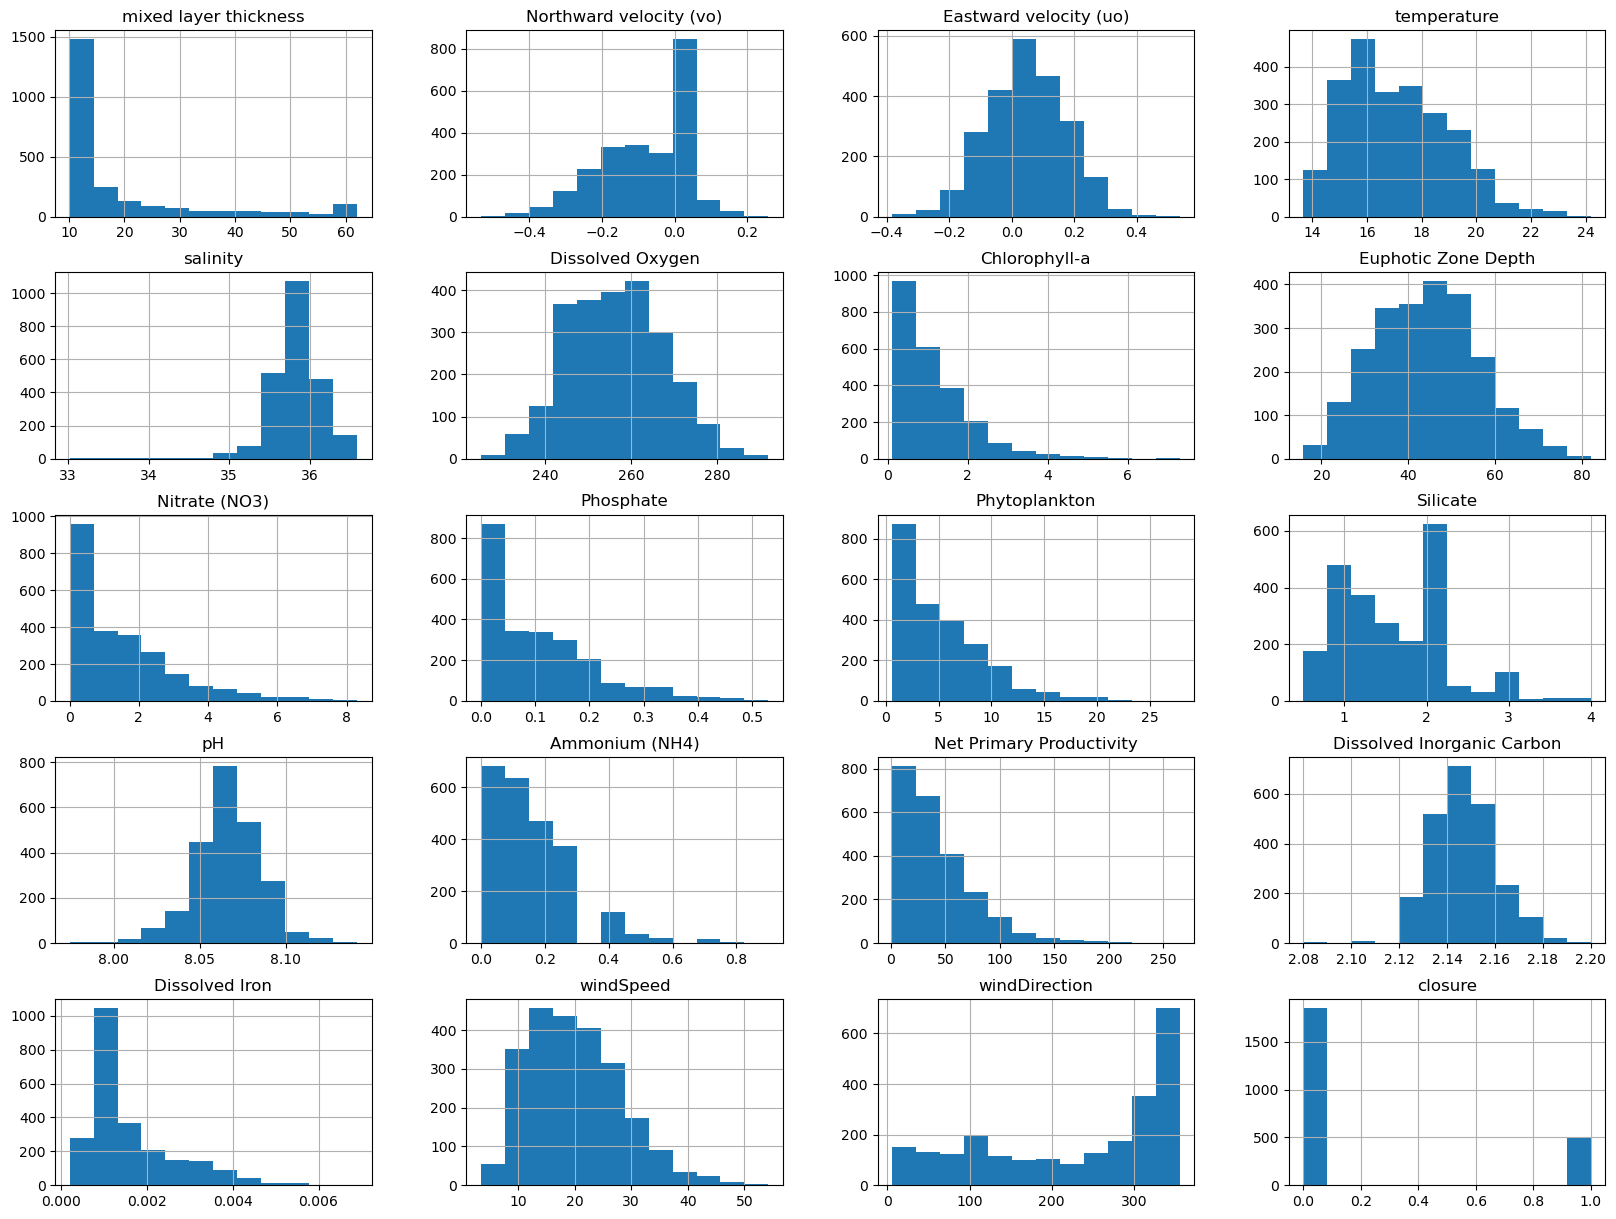

In [8]:

df_barplot = df_merge.copy(deep=True)
df_barplot.drop(['state', 'Day of year', 'Partial pressure of CO2', 'Sea surface height'], inplace = True, axis = 1)

df_barplot['closure'] = df_merge['state']
# plot an overview of the distribution of each column
ax = df_barplot.hist(figsize=(20,15), bins = 12)

df_merge.keys()



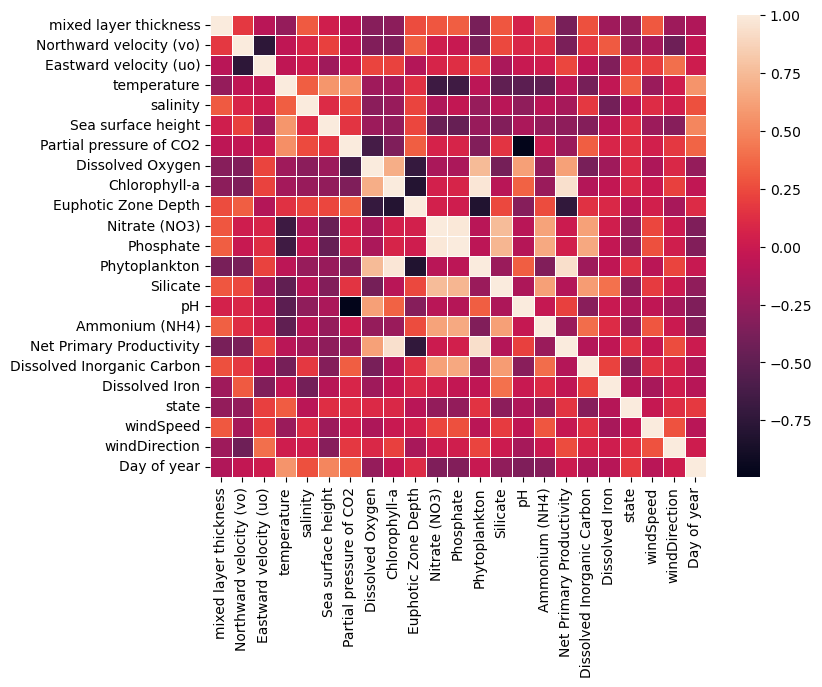

In [9]:
## Correlation between the different data
plt.figure(figsize=(8,6))
sns.heatmap(df_merge.corr(),  cbar=True, linewidths=0.5);

In [10]:
## X & Y

X = df_merge.drop(['state'],axis=1)
y = df_merge['state']
print(df_merge.shape, X.shape, y.shape)
df_merge.keys()
df_merge.to_csv('./training_data/training_data.csv')
print(np.sum(y==1)/len(y))
print(np.sum(y==1),len(y))

(2353, 23) (2353, 22) (2353,)
0.21121971950701232
497 2353


# Train test data split
We want to split so that time dimension is retained but to also ensure that the 
test data contains reasonable amount of closures. This split provides the best performance
```
n_test = int(X.shape[0]*0.2)
train_ind = np.concatenate( (np.arange(0, 2*n_test), np.arange(3*n_test, X.shape[0])), axis = 0)
test_ind = np.arange(2*n_test, 3*n_test)
```

(1883, 22) (470,) (1883, 22)
171
2017-08-28 2019-01-01


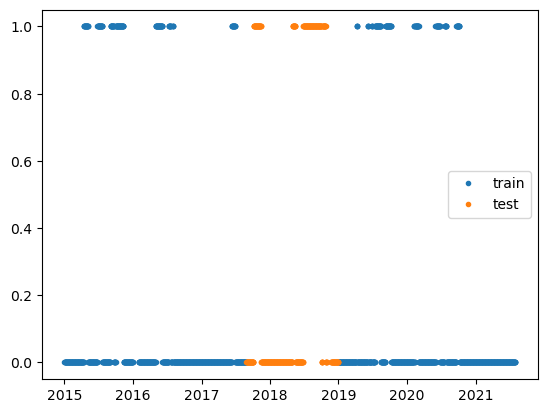

In [11]:
n_test = int(X.shape[0]*0.2)
train_ind = np.concatenate( (np.arange(0, 2*n_test), np.arange(3*n_test, X.shape[0])), axis = 0)
test_ind = np.arange(2*n_test, 3*n_test)
X_test = X.iloc[test_ind]
X_train = X.iloc[train_ind]
y_test = y.iloc[test_ind]
y_train = y.iloc[train_ind]

print(X_train.shape, y_test.shape, X_train.shape)
#plt.plot(y_train.index, y_train)
plt.plot(y_train, '.', label = 'train')
plt.plot(y_test, '.', label = 'test')
plt.legend()
print(np.sum(y_test==1))
print(X_test.index[0], X_test.index[-1])

# Now we resample the data
Note that we only resample the training data

In [12]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


# summarize class distribution
print('raw data', Counter(y_train))
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.5)
# fit and apply the transform
X_train_s, y_train_s = over.fit_resample(X_train, y_train)
# summarize class distribution
print('oversample' , Counter(y_train_s))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.6)
# fit and apply the transform
X_train_s, y_train_s = under.fit_resample(X_train_s, y_train_s)
# summarize class distribution
print('undersample' , Counter(y_train_s))
print(Counter(y), Counter(y_train), Counter(y_train_s))


raw data Counter({0.0: 1557, 1.0: 326})
oversample Counter({0.0: 1557, 1.0: 778})
undersample Counter({0.0: 1296, 1.0: 778})
Counter({0.0: 1856, 1.0: 497}) Counter({0.0: 1557, 1.0: 326}) Counter({0.0: 1296, 1.0: 778})


In [13]:
from sklearn.preprocessing import RobustScaler as rb
from lale.lib.lale import ConcatFeatures as Concat
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.linear_model import SGDClassifier
from lale.lib.lale import TopKVotingClassifier
from sklearn.linear_model import LogisticRegression as LR
lale.wrap_imported_operators()

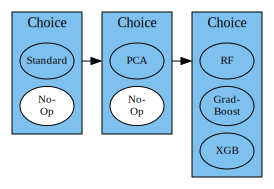

In [14]:
planned_pipe = (Standard | NoOp) >> (PCA | NoOp) >> (RF|GradBoost|XGB) 

#planned_pipe = (Standard|NoOp) >> ( XGB) 
#planned_pipe =(NoOp |  rb)  >>  RF
fig = planned_pipe.visualize()

## First let's train a model on the raw data with no re sampling
Our model is `trained_clf_no_sampling`

In [15]:
# There is no real reason for us to have this model since tests show that standardising
# does improve performance

trainable_pipe_no_sampling = Hyperopt(estimator = planned_pipe, cv = 10, 
                              max_evals = 10, scoring='accuracy')
# train our model with no resampling
trained_clf_no_sampling = trainable_pipe_no_sampling.fit(X_train, y_train)

100%|██████████| 10/10 [00:31<00:00,  3.17s/trial, best loss: -0.8268743667679838]


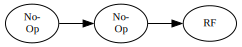

In [16]:
trained_clf_no_sampling.get_pipeline().visualize()

## Our second model considers a model with resampling
Note, that we can redo the algorithm search but previous simulations demonstrate that XGB gives best performance

In [17]:
# Consider what to use as loss metric rmse or mse
cross_val = 10
max_evals = 200
planned_pipe = (NoOp | Standard )  >> XGB 
trainable_pipe_resample = Hyperopt(estimator = planned_pipe, cv = cross_val, 
                              max_evals = max_evals, scoring='accuracy')

# Finally we train the classifier on the resampled data
trained_resample = trainable_pipe_resample.fit(X_train_s, y_train_s)



100%|██████████| 5/5 [00:33<00:00,  6.70s/trial, best loss: -0.9730258268301748]


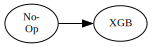

In [18]:
trained_resample.get_pipeline().visualize()


## 3) Final model is an ensemble forecasting model

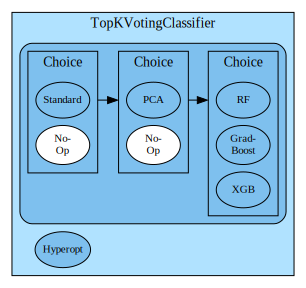

In [19]:

planned_pipeline = (Standard | NoOp) >> (PCA | NoOp) >> (RF|GradBoost|XGB) #|MLPClassifier) 

ensemble = TopKVotingClassifier(
    estimator=planned_pipeline, k=10, optimizer=Hyperopt,
    args_to_optimizer={'max_evals':5, 'scoring':'accuracy'})
fig = ensemble.visualize()



## And train ensemble model

In [20]:
trained_ensemble = ensemble.fit(X_train_s, y_train_s)

100%|██████████| 1/1 [00:06<00:00,  6.76s/trial, best loss: -0.709112391595367]


0.7638297872340426


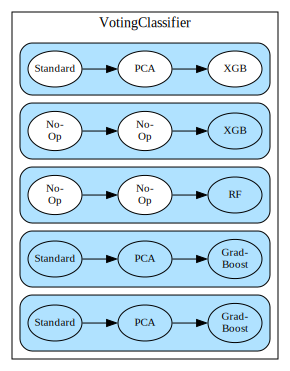

In [21]:
predictions = trained_ensemble.predict(X_test)
print(accuracy_score(y_test, predictions))
trained_ensemble.get_pipeline().visualize()

In [22]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def acc_prec_rec(y_test, X_test, model):
    '''
    Function to return the accuracy, precision, recall, and f1 score of model.
    For precision we return both precision (p=0.5) and average precision.
    The precision-recall curve plots precision and recall for different probability thresholds p. 
    For p=0, everything is classified as 1 so recall will be 100% and precision will be the 
    proportion of 1's in your test dataset. For p=1, nothing is classified as 1, so recall will 
    be 0% and precision will be 0. For p=0.5, that's what precision_score tells you, however, you 
    probably won't want to use this threshold in you're final model, you'll choose a different 
    threshold depending on the number of false positives you're willing to tolerate. So the average 
    precision score gives you the average precision of all the different threshold choices.
    '''
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    ave_precision = average_precision_score(y_test, pred)

    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    return accuracy, ave_precision, precision, recall, f1

In [23]:
"""
trained_models  = [trained_xgb,
                    trained_xgb_auc,
                    trained_rf,trained_rf_auc,
                    trained_KNN,trained_knn_auc,
                    trained_GradBoost,
                    trained_ExtraTreesClassifier,
                    stacked_model, 
                    ensemble,
                    ensemble_s,
                    trained_ensemble,
                    trained_LR,
                    trained_clf_no_sampling
]
"""
#xgb_temp = xgb_params.fit(X_train_s, y_train_s)

trained_models  = {"BPIM":  trained_clf_no_sampling,
                   "BPIM_S": trained_resample, # trained_xgb,
                   "Ensemble": trained_ensemble,    
                  }

for model in trained_models:
    acc, ave_prec, prec, recall, f1 = acc_prec_rec(y_test, X_test, trained_models[model])
    print('Accuracy, precision, recall, and f1_score for {} are {:.2}, {:.2}, {:.2}, and {:.2}, respectively'.
          format(model, acc, prec, recall, f1))


    

Accuracy, precision, recall, and f1_score for BPIM are 0.64, 0.0, 0.0, and 0.0, respectively
Accuracy, precision, recall, and f1_score for BPIM_S are 0.78, 0.96, 0.41, and 0.57, respectively
Accuracy, precision, recall, and f1_score for Ensemble are 0.76, 0.83, 0.44, and 0.58, respectively


In [25]:
from sklearn.metrics import confusion_matrix
for model in trained_models:
    pred = trained_models[model].predict(X_test)
    print(f'The confusion matrix for model {model} is')
    print(confusion_matrix(y_test, pred))
#print(confusion_matrix(y_test, trained_xgb.predict(X_test)))

print(y_train.shape, y_test.shape)
np.sum(trained_models['BPIM'].predict(X_test))


The confusion matrix for model BPIM is
[[299   0]
 [171   0]]
The confusion matrix for model BPIM_S is
[[296   3]
 [101  70]]
The confusion matrix for model Ensemble is
[[283  16]
 [ 95  76]]
(1883,) (470,)


0.0

In [54]:
trained_models_params


{'BPIM': XGB(gamma=0.027198602018016604, learning_rate=0.7126553702940439, max_depth=3, min_child_weight=16, n_estimators=656, reg_alpha=0.37804783806967546, reg_lambda=0.25086907566849703, subsample=0.10181214290450248),
 'BPIM_S': XGB(gamma=0.7515525313404963, learning_rate=0.17233909296953243, max_depth=4, min_child_weight=5, n_estimators=462, reg_alpha=0.10485915855270356, reg_lambda=0.9268502695024392, subsample=0.4503841871781402),
 'Ensemble': VotingClassifier(estimators=[('p25', lale.operators.<lale.operators.TrainablePipeline object at 0x10d69cca0>), ('p30', lale.operators.<lale.operators.TrainablePipeline object at 0x10d69cd30>), ('p29', lale.operators.<lale.operators.TrainablePipeline object at 0x1636fb3a0>), ('p45', lale.operators.<lale.operators.TrainablePipeline object at 0x163c5ec40>)], voting='soft')}

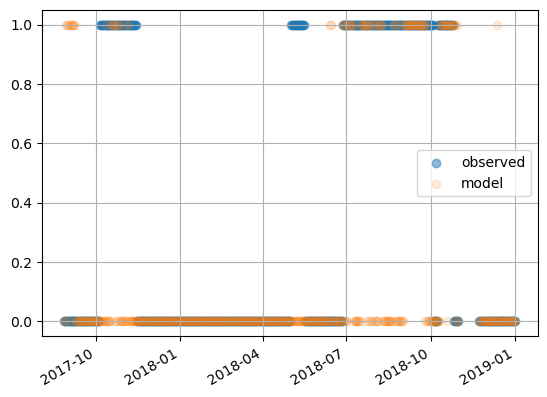

NameError: name 'fig_dir' is not defined

In [26]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
import matplotlib.dates as mdates
years = mdates.YearLocator()   
months = mdates.MonthLocator(range(1,13,3))  
years_fmt = mdates.DateFormatter('% Y')

classes = np.unique(y_test)
fig, ax = plt.subplots()
pred = trained_ensemble.predict(X_test)

ax.scatter(y_test.index, y_test,  label = 'observed', alpha=0.5)
ax.scatter(y_test.index, pred,  label = 'model', alpha=0.15)
ax.xaxis.set_major_locator(months) 
ax.legend()
ax.grid()
fig.autofmt_xdate()

plt.show()
fig.savefig(fig_dir + 'confusion_timeseries.png')